In [1]:

import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch
from sentence_transformers import SentenceTransformer, util

2024-07-16 15:22:39.282521: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 15:22:39.289081: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 15:22:39.387734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 15:22:41.227496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/claney/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebo

# Unzipping csv file

In [137]:

uploaded_zip = '/home/claney/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/claney/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
full_df = pd.read_csv(csv_file)

In [138]:
full_df.fillna(0,inplace=True)

# Spliting testing and training

In [139]:
df_sorted = full_df.sort_values(by='Created_time')


In [169]:
full_df.size

936716

In [140]:
length=len(df_sorted)
split_index=int(.8*length)
df=df_sorted.iloc[:split_index] #df=training set


In [170]:
df.size

749364

In [ ]:
df.head()

# Creating isDuplicate column

In [6]:
def is_duplicate(val):
    return 1 if val !=0.0 else 0
df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))

print(df['isDuplicate'])

0        0
12       0
11       0
10       0
9        0
        ..
68119    0
68120    0
68121    0
68122    0
68123    0
Name: isDuplicate, Length: 68124, dtype: int64


/tmp/ipykernel_193578/1537637410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))


isDuplicate
0    56126
1    11998
Name: count, dtype: int64


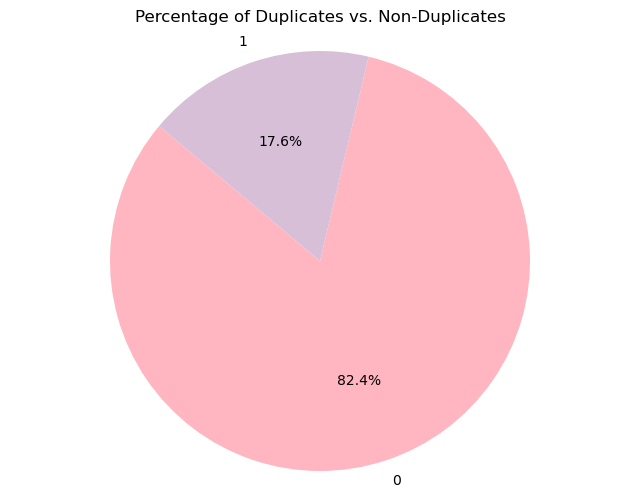

In [7]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'isDuplicate' is the column indicating duplicates
duplicate_counts = df['isDuplicate'].value_counts()

# Check the contents of duplicate_counts
print(duplicate_counts)

# Create a list of labels matching the length of duplicate_counts
# Ensure the labels match the values in the 'isDuplicate' column
labels = duplicate_counts.index.tolist()

# Define colors (length should match number of unique values in 'isDuplicate')
colors = ['#FFB6C1', '#D8BFD8'][:len(labels)]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(duplicate_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Duplicates vs. Non-Duplicates')
plt.axis('equal')
plt.show()


# Preprocessing

In [8]:
df['Description'] = df['Description'].astype(str).fillna('')

/tmp/ipykernel_193578/77102330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].astype(str).fillna('')


In [9]:
#creating freeform textual data column
df['full_text_data']=df['Description']+df['Title']
print(df['full_text_data'])
df['full_text_data']=df['full_text_data'].fillna('')

0        - Setup a project that contains a *.gif resour...
12       Would it make sense to have a (the?) projects ...
11       Currently every new resource added to a shared...
10       Jean-Michel (08/02/2001 1:38:48 PM); ; The ISh...
9        There seems to be a need for a VCM Event notif...
                               ...                        
68119    Build ID: 3.3 (I am not sure what You mean by ...
68120    There are several NPEs within the UI session t...
68121    I20080501-0100; ; Now that were using the coll...
68122    Created attachment 98318; screenshot; ; I20080...
68123    Build ID: M20080221-1800; ; Steps To Reproduce...
Name: full_text_data, Length: 68124, dtype: object


/tmp/ipykernel_193578/3345744263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['Description']+df['Title']
/tmp/ipykernel_193578/3345744263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['full_text_data'].fillna('')


,full_text_data,Duplicate_issue
0,bug report 1,[2]
1,bug report 2,[]
2,bug report 3,[1]
3,bug report 4,[]


# Creating topics using LDA

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')

# Fit and transform the CountVectorizer on the text data
counts = count_vectorizer.fit_transform(df['full_text_data'])

count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
counts = count_vectorizer.fit_transform(df['full_text_data'])

        # Fit LDA model
lda = LatentDirichletAllocation(n_components=7, max_iter=10,learning_method='online',learning_offset=50.,random_state=0)
lda.fit(counts)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=7, random_state=0)

In [11]:
feature_names = count_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-20 - 1:-1]]))
        
        print()

Topic 1:
swt display widgets shell eclipse org new control ljava composite os junit framework dylib import widget lorg windowproc win32 event

Topic 2:
eclipse org osgi core framework update plugins message com ui help jar bundle platform xml equinox ant http apache plugin

Topic 3:
line editor view new open public menu text window int button item does string null click object perspective tab selection

Topic 4:
eclipse lib 03 00000000 usr dll 00 object org jar xp system32 java lang windows plugins rwxp jre 08 02

Topic 5:
java org eclipse internal ui core run swt main workbench widgets jface runtime lang method display reflect launcher widget invoke

Topic 6:
text search table image gtk styledtext linux font column color string width icons background characters abstractdocument index windows size markers

Topic 7:
file project eclipse build cvs dialog error view new workspace files use using does problem bug user create like set



In [12]:
#for alll columns in the df 
#compare each bug report to each topic 
#if
topic_distributions = lda.transform(counts)

In [13]:
df['topic'] = topic_distributions.argmax(axis=1)

# Create DataFrames for each topic
topic_dfs = []
for topic_idx in range(7):
    topic_df = df[df['topic'] == topic_idx].copy()
    topic_dfs.append(topic_df)

# Display the DataFrames for each topic
for i, topic_df in enumerate(topic_dfs):
    print(f"Topic {i}:")
    print(topic_df['full_text_data'])
    print()

#save each DataFrame to a CSV file
for i, topic_df in enumerate(topic_dfs):
    topic_df.to_csv(f'topic_{i}_bug_reports.csv', index=False)

/tmp/ipykernel_193578/3871166757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_distributions.argmax(axis=1)


Topic 0:
216      While minimizing an Eclipse running in Eclipse...
330      DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...
416      Debugger Stack Trace Report:; ; Thread[main;5;...
1202     Create a TextViewer; give it a string for its ...
1308     Self hosting Eclipse; my target workbench cras...
                               ...                        
67999    using org.eclipse.swt_3.4.0.v3436a.jar and org...
68000    using org.eclipse.swt_3.4.0.v3436a.jar and org...
68040    Here is the follow up got Bug 227968. The prob...
68105    - run the snippet below; - note that the main ...
68118    swt.jar from the I20080429-0100 build; setRegi...
Name: full_text_data, Length: 1504, dtype: object

Topic 1:
245      I created a new stream in the repository; made...
221      prefix        test; name          181178; refe...
295      |     To:  Brian Young/OTT/OTI@OTI; Dave Thoms...
319      MF (6/5/01 12:10:21 PM); \t\twe silently ignor...
321      Please respond to Susan Griffin/OTT/O

In [14]:
topic_0_df=pd.read_csv('topic_0_bug_reports.csv')
topic_1_df=pd.read_csv('topic_1_bug_reports.csv')
topic_2_df=pd.read_csv('topic_2_bug_reports.csv')
topic_3_df=pd.read_csv('topic_3_bug_reports.csv')
topic_4_df=pd.read_csv('topic_4_bug_reports.csv')
topic_5_df=pd.read_csv('topic_5_bug_reports.csv')
topic_6_df=pd.read_csv('topic_6_bug_reports.csv')


#storaging them in seperate csv so when we do classifciaton on them its alll seperate 

# Cosine similarity top-K

In [149]:
import torch
from sentence_transformers import SentenceTransformer, util
import pandas as pd

def get_top_k_similar(df, k, model_name='paraphrase-MiniLM-L6-v2'):
    # Load the model
    model = SentenceTransformer(model_name)
    
    # Encode sentences and store the embeddings in the DataFrame
    df['embeddings'] = df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))
    
    # Convert embeddings to a tensor
    embeddings = torch.stack(df['embeddings'].tolist())
    
    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    
    # Store the top k similar pairs
    top_k_similarities = {}
    for i in range(len(cosine_scores)):
        top_k_similarities[i] = sorted(
            [(j, cosine_scores[i][j].item()) for j in range(len(cosine_scores)) if i != j], 
            key=lambda x: x[1], 
            reverse=True
        )[:k]
    
    # Create a new column to store the experimental duplicate Issue IDs
    df['Experimental_Duplicate_IDs'] = df.index.map(
        lambda idx: [df.loc[pair[0], 'Issue_id'] for pair in top_k_similarities[idx]]
    )

    return df

    


In [150]:
get_top_k_similar(test_df,5)
print(test_df)

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


      Issue_id Priority Component  Duplicated_issue  \
0          217       P3      Team               0.0   
1         1533       P2     Debug               0.0   
2         1850       P3        UI               0.0   
3         2650       P3        UI               0.0   
4         2760       P3        UI               0.0   
...        ...      ...       ...               ...   
1499    228762       P3       SWT               0.0   
1500    228770       P3       SWT               0.0   
1501    229172       P3       SWT               0.0   
1502    229680       P3       SWT               0.0   
1503    229776       P3       SWT               0.0   

                                                  Title  \
0                          UI BUG TO BE FILED (1GHQOGF)   
1     Feature: notification of changing variables (1...   
2                    WALKBACK - EditableTable (1G5T6MC)   
3     [JFace Text] TextViewer#setVisibleRegion doesn...   
4     Workbench resizing crash (stack overfl

In [99]:
def recallRateAtK(k, top_k_recommendations_df):
    #updates the row called Experimental_Duplicate_IDs to have the top k most similar bug ids
    #top_k_recommendations_df=get_top_k_similar(df)
    #need to find how many of te top are relevant aka when the real ids match the expirmental ids 
    exp_ids = top_k_recommendations_df['Experimental_Duplicate_IDs'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    print(exp_ids)
    dup_ids = top_k_recommendations_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    print(dup_ids)
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [str(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [str(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches
    num_matches = matches.sum()
    
    recallRateAtk=num_matches/k
    return recallRateAtk

In [109]:
# Define a function to count the matching elements
def count_matching_elements(df):
    set1 = set(test_df['Experimental_Duplicate_IDs'])
    set2 = set(test_df['Duplicated_issue'])
    return len(set1 & set2)

# Apply the function to each row
test_df['matching_count'] = test_df.apply(count_matching_elements, axis=1)

print(test_df)

TypeError: unhashable type: 'list'

In [120]:
def countMatches(df):
    exp_ids = df['Experimental_Duplicate_IDs'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    print(type(exp_ids))
    print(exp_ids)
    dup_ids = df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    print(type(dup_ids))
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    return matches.sum()
    

In [135]:
# Display rows where 'Duplicated_issue' is not zero
filtered_df = test_df[test_df['Duplicated_issue'] != 0]

print(filtered_df.head(50))

     Issue_id Priority  Component  Duplicated_issue  \
13       4484       P5        SWT           63105.0   
19       4505       P5        SWT           13467.0   
29       4571       P4        SWT            4812.0   
35       4760       P3        SWT            6325.0   
50       5130       P3        SWT            4664.0   
54       6172       P3        SWT          294986.0   
94      11660       P3        SWT           23980.0   
99      12356       P3        SWT            4805.0   
133     15647       P3        SWT           15603.0   
139     17372       P3        SWT           18534.0   
148     18461       P3        SWT            4730.0   
152     19210       P3        SWT           29302.0   
212     23135       P2        SWT           26563.0   
223     24208       P3  Resources           23135.0   
226     24362       P3        SWT           26095.0   
242     26342       P3        SWT           23135.0   
244     26499       P3        SWT           30073.0   
259     28

In [133]:
test_df.head(50)

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time,isDuplicate,full_text_data,topic,embeddings,Experimental_Duplicate_IDs,matching_count
0,217,P3,Team,0.0,UI BUG TO BE FILED (1GHQOGF),While minimizing an Eclipse running in Eclipse...,RESOLVED,INVALID,2.0,2001-10-10 21:38:00 -0400,2001-10-23 23:47:22 -0400,0,While minimizing an Eclipse running in Eclipse...,0,"[tensor(-0.1557), tensor(-0.0240), tensor(0.05...","[37, 127, 254, 4, 33]",0
1,1533,P2,Debug,0.0,Feature: notification of changing variables (1...,DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2002-02-04 13:16:45 -0500,0,DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...,0,"[tensor(-0.1963), tensor(0.2270), tensor(-0.05...","[952, 1380, 1066, 253, 948]",0
2,1850,P3,UI,0.0,WALKBACK - EditableTable (1G5T6MC),Debugger Stack Trace Report:; ; Thread[main;5;...,RESOLVED,FIXED,2.0,2001-10-10 22:20:00 -0400,2001-11-13 15:30:56 -0500,0,Debugger Stack Trace Report:; ; Thread[main;5;...,0,"[tensor(-0.4983), tensor(-0.2631), tensor(0.03...","[129, 1116, 158, 617, 313]",0
3,2650,P3,UI,0.0,[JFace Text] TextViewer#setVisibleRegion doesn...,Create a TextViewer; give it a string for its ...,RESOLVED,WONTFIX,2.0,2001-10-10 22:40:00 -0400,2009-08-30 02:31:49 -0400,0,Create a TextViewer; give it a string for its ...,0,"[tensor(-0.0025), tensor(0.0376), tensor(-0.17...","[746, 810, 1399, 1411, 749]",0
4,2760,P3,UI,0.0,Workbench resizing crash (stack overflow) (1GI...,Self hosting Eclipse; my target workbench cras...,RESOLVED,INVALID,2.0,2001-10-10 22:43:00 -0400,2002-01-08 15:59:57 -0500,0,Self hosting Eclipse; my target workbench cras...,0,"[tensor(0.1617), tensor(-0.0578), tensor(0.014...","[0, 37, 127, 463, 464]",0
5,2778,P1,UI,0.0,ViewsPreferencePage slams parents data (1GJ6K5U),The method createButtonGroup(Composite composi...,RESOLVED,FIXED,2.0,2001-10-10 22:43:00 -0400,2001-11-26 09:48:01 -0500,0,The method createButtonGroup(Composite composi...,0,"[tensor(-0.3491), tensor(-0.3802), tensor(-0.1...","[240, 203, 596, 345, 950]",0
6,4434,P4,SWT,0.0,GPF when running SWT Tree code (1FNI25V),What I did to produce this GPF was set the tre...,RESOLVED,FIXED,2.0,2001-10-11 14:16:00 -0400,2003-03-12 16:12:15 -0500,0,What I did to produce this GPF was set the tre...,0,"[tensor(-0.1549), tensor(-0.1092), tensor(-0.1...","[487, 400, 776, 1069, 177]",0
7,4426,P5,SWT,0.0,ScrollBar - Cant query size (1FDVP23),There is no way to query the size of a ScrollB...,RESOLVED,FIXED,2.0,2001-10-11 14:16:00 -0400,2002-05-27 10:33:46 -0400,0,There is no way to query the size of a ScrollB...,0,"[tensor(0.0338), tensor(0.0589), tensor(-0.356...","[130, 92, 1275, 1013, 278]",0
8,4443,P5,SWT,0.0,Layout: Exceptions when horizontalSpan > remai...,Run the code below. ; You will get a NullPoint...,RESOLVED,FIXED,2.0,2001-10-11 14:16:00 -0400,2002-03-07 10:29:48 -0500,0,Run the code below. ; You will get a NullPoint...,0,"[tensor(-0.0721), tensor(-0.1123), tensor(-0.2...","[881, 1416, 1095, 66, 16]",0
9,4395,P5,SWT,0.0,DCR - SWT.CLIP_SIBLINGS must be repeated in al...,In applications that allow the user to move a ...,RESOLVED,WONTFIX,2.0,2001-10-11 14:16:00 -0400,2002-05-15 21:39:22 -0400,0,In applications that allow the user to move a ...,0,"[tensor(-0.4707), tensor(-0.2893), tensor(-0.2...","[443, 184, 222, 535, 924]",0


In [153]:
import pandas as pd
from itertools import chain
import numpy as np


# Function to flatten a list
def flatten_list(lst):
    if not isinstance(lst, list):
        return []
    return list(chain.from_iterable(
        sublist if isinstance(sublist, list) else [sublist] for sublist in lst
    ))

# Define a function to count the matching elements
def count_matching_elements(df):
    set1 = set(flatten_list(df['Experimental_Duplicate_IDs']))
    set2 = set(flatten_list(df['Duplicated_issue']))
    return len(set1 & set2)

# Apply the function to each row
test_df['matching_count'] = test_df.apply(lambda row: count_matching_elements(row), axis=1)

print(test_df)

# Filter rows where matching_count is not equal to 0
filtered_df = test_df[test_df['matching_count'] != 0]

print(filtered_df)

      Issue_id Priority Component  Duplicated_issue  \
0          217       P3      Team               0.0   
1         1533       P2     Debug               0.0   
2         1850       P3        UI               0.0   
3         2650       P3        UI               0.0   
4         2760       P3        UI               0.0   
...        ...      ...       ...               ...   
1499    228762       P3       SWT               0.0   
1500    228770       P3       SWT               0.0   
1501    229172       P3       SWT               0.0   
1502    229680       P3       SWT               0.0   
1503    229776       P3       SWT               0.0   

                                                  Title  \
0                          UI BUG TO BE FILED (1GHQOGF)   
1     Feature: notification of changing variables (1...   
2                    WALKBACK - EditableTable (1G5T6MC)   
3     [JFace Text] TextViewer#setVisibleRegion doesn...   
4     Workbench resizing crash (stack overfl

In [121]:
print(countMatches(test_df))

<class 'pandas.core.series.Series'>
0              [[37,, 127,, 254,, 4,, 33]]
1        [[952,, 1380,, 1066,, 253,, 948]]
2         [[129,, 1116,, 158,, 617,, 313]]
3        [[746,, 810,, 1399,, 1411,, 749]]
4             [[0,, 37,, 127,, 463,, 464]]
                       ...                
1499    [[1500,, 849,, 1503,, 716,, 1458]]
1500     [[1499,, 849,, 1503,, 831,, 107]]
1501      [[663,, 473,, 1045,, 861,, 797]]
1502     [[779,, 1064,, 845,, 1464,, 815]]
1503     [[1317,, 1398,, 1210,, 99,, 964]]
Name: Experimental_Duplicate_IDs, Length: 1504, dtype: object
<class 'pandas.core.series.Series'>
0


In [100]:
print(recallRateAtK(5,test_df))

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0              [[37,, 127,, 254,, 4,, 33]]
1        [[952,, 1380,, 1066,, 253,, 948]]
2         [[129,, 1116,, 158,, 617,, 313]]
3        [[746,, 810,, 1399,, 1411,, 749]]
4             [[0,, 37,, 127,, 463,, 464]]
                       ...                
1499    [[1500,, 849,, 1503,, 716,, 1458]]
1500     [[1499,, 849,, 1503,, 831,, 107]]
1501      [[663,, 473,, 1045,, 861,, 797]]
1502     [[779,, 1064,, 845,, 1464,, 815]]
1503     [[1317,, 1398,, 1210,, 99,, 964]]
Name: Experimental_Duplicate_IDs, Length: 1504, dtype: object
0       [0.0]
1       [0.0]
2       [0.0]
3       [0.0]
4       [0.0]
        ...  
1499    [0.0]
1500    [0.0]
1501    [0.0]
1502    [0.0]
1503    [0.0]
Name: Duplicated_issue, Length: 1504, dtype: object


ValueError: could not convert string to float: '[37,'

In [108]:
test_df=topic_0_df.copy()
print(test_df.head())
print(type(test_df['Experimental_Duplicate_IDs']))
test_df['Experimental_Duplicate_IDs'].tolist()
print(type(test_df['Experimental_Duplicate_IDs']))

   Issue_id Priority Component  Duplicated_issue  \
0       217       P3      Team               0.0   
1      1533       P2     Debug               0.0   
2      1850       P3        UI               0.0   
3      2650       P3        UI               0.0   
4      2760       P3        UI               0.0   

                                               Title  \
0                       UI BUG TO BE FILED (1GHQOGF)   
1  Feature: notification of changing variables (1...   
2                 WALKBACK - EditableTable (1G5T6MC)   
3  [JFace Text] TextViewer#setVisibleRegion doesn...   
4  Workbench resizing crash (stack overflow) (1GI...   

                                         Description    Status Resolution  \
0  While minimizing an Eclipse running in Eclipse...  RESOLVED    INVALID   
1  DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...  VERIFIED      FIXED   
2  Debugger Stack Trace Report:; ; Thread[main;5;...  RESOLVED      FIXED   
3  Create a TextViewer; give it a string f

In [26]:
def accuracy(topic_x_df):
    #a match is considered if there are any matching values in exp_ids and dup_ids 
       # Split the IDs by spaces and strip whitespace
    
    exp_ids = topic_x_df['Experimental_Duplicate_IDs'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    print(exp_ids)
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    print(dup_ids)
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches
    num_matches = matches.sum()
    accuracy=num_matches/len(topic_x_df)
    return accuracy


In [89]:
def recall_at_k(df):

    # Calculate the number of relevant items in the predictions
    relevant_items = len(set(df['Duplicated_issue']) & set(df['Experimental_Duplicate_IDs']))
    
    # Calculate recall
    recall = relevant_items / len(df['Duplicated_issue'])
    return recall


In [51]:
len(topic_0_df['Experimental_Duplicate_IDs'])

1504

In [52]:

topic_0_df['Recall@k'] = topic_0_df.apply(lambda row: recall_at_k(topic_0_df), axis=1)

# Calculate average Recall@k
average_recall_at_k = topic_0_df['Recall@k'].mean()

print(f"Average Recall@{k}: {average_recall_at_k}")

# Output the dataframe to see individual recall values
print(df)

TypeError: unhashable type: 'list'

In [17]:
topic_0_df=get_top_k_similar(topic_0_df)

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
print(topic_0_df.head(20))

    Issue_id Priority Component  Duplicated_issue  \
0        217       P3      Team               0.0   
1       1533       P2     Debug               0.0   
2       1850       P3        UI               0.0   
3       2650       P3        UI               0.0   
4       2760       P3        UI               0.0   
5       2778       P1        UI               0.0   
6       4434       P4       SWT               0.0   
7       4426       P5       SWT               0.0   
8       4443       P5       SWT               0.0   
9       4395       P5       SWT               0.0   
10      4392       P5       SWT               0.0   
11      4407       P5       SWT               0.0   
12      4410       P5       SWT               0.0   
13      4484       P5       SWT           63105.0   
14      4506       P5       SWT               0.0   
15      4482       P5       SWT               0.0   
16      4492       P5       SWT               0.0   
17      4494       P5       SWT               

In [147]:
print(topic_0_df.shape)

(1504, 16)


In [27]:
accuracy(topic_0_df)

0              [[37,, 127,, 254,, 4,, 33]]
1        [[952,, 1380,, 1066,, 253,, 948]]
2         [[129,, 1116,, 158,, 617,, 313]]
3        [[746,, 810,, 1399,, 1411,, 749]]
4             [[0,, 37,, 127,, 463,, 464]]
                       ...                
1499    [[1500,, 849,, 1503,, 716,, 1458]]
1500     [[1499,, 849,, 1503,, 831,, 107]]
1501      [[663,, 473,, 1045,, 861,, 797]]
1502     [[779,, 1064,, 845,, 1464,, 815]]
1503     [[1317,, 1398,, 1210,, 99,, 964]]
Name: Experimental_Duplicate_IDs, Length: 1504, dtype: object
0       [0.0]
1       [0.0]
2       [0.0]
3       [0.0]
4       [0.0]
        ...  
1499    [0.0]
1500    [0.0]
1501    [0.0]
1502    [0.0]
1503    [0.0]
Name: Duplicated_issue, Length: 1504, dtype: object


NameError: name 'String' is not defined

In [28]:
topic_1_df=get_top_k_similar(topic_1_df)
topic_2_df=get_top_k_similar(topic_2_df)
topic_3_df=get_top_k_similar(topic_3_df)
topic_4_df=get_top_k_similar(topic_4_df)
topic_5_df=get_top_k_similar(topic_5_df)
topic_6_df=get_top_k_similar(topic_6_df)

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resum

In [ ]:
def experimentalisDuplicate(topic_x_df): #creates column for experimental binary isDuplciates
    def is_duplicate(val):
        return 1 if val !=(0.0 or 0) else 0
    topic_x_df['isExperimentalDuplicate'] = topic_x_df['Experimental_Duplicate_ID'].apply(lambda x: is_duplicate(x))
    return topic_x_df['isExperimentalDuplicate']

In [ ]:
def binaryAccuracy(topic_x_df): #see if the ones and zeros match, different from other acuracy becuase that one can have only one element mathc and it count ex bug 1 has ids 1234 and 8472 it should still count as a duplciate to bug 2 with 1234 0889 
    matches=topic_x_df['isExperimentalDuplicate']==topic_x_df['isDuplicate']
    num_matches=matches.sum()
    accuracy=num_matches/len(topic_x_df['isExperimentalDuplicate'])
    return accuracy

In [ ]:
# Initialize lists to store the results
accuracy_values = []
binary_accuracy_values = []
recall_values = []
precision_values = []
f1_values = []
topic_dfs = [topic_0_df, topic_1_df, topic_2_df, topic_3_df, topic_4_df, topic_5_df, topic_6_df]
# Perform the analysis and store the results
for x in range(7):
    df = topic_dfs[x]

    df['Experimental_Duplicate_ID'] = get_top_k_similar(0.85, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values.append(accuracyVal)
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values.append(binaryAccuracyVal)
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values.append(recallVal)
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values.append(precisionVal)
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values.append(f1Val)
    print(f"F1 score for topic {x} is %{f1Val:.2f}")

In [72]:
topic_0_copy=topic_0_df.copy()

In [82]:
print(topic_0_copy.head(20))

    Issue_id Priority Component  Duplicated_issue  \
0        217       P3      Team               0.0   
1       1533       P2     Debug               0.0   
2       1850       P3        UI               0.0   
3       2650       P3        UI               0.0   
4       2760       P3        UI               0.0   
5       2778       P1        UI               0.0   
6       4434       P4       SWT               0.0   
7       4426       P5       SWT               0.0   
8       4443       P5       SWT               0.0   
9       4395       P5       SWT               0.0   
10      4392       P5       SWT               0.0   
11      4407       P5       SWT               0.0   
12      4410       P5       SWT               0.0   
13      4484       P5       SWT           63105.0   
14      4506       P5       SWT               0.0   
15      4482       P5       SWT               0.0   
16      4492       P5       SWT               0.0   
17      4494       P5       SWT               

In [151]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_matrix(feature_vectors):
    """
    Compute cosine similarity matrix for a set of feature vectors.
    
    Parameters:
    feature_vectors (np.ndarray): Array of shape (n_samples, n_features) containing feature vectors.
    
    Returns:
    np.ndarray: Cosine similarity matrix of shape (n_samples, n_samples).
    """
    similarity_matrix = cosine_similarity(feature_vectors)
    np.fill_diagonal(similarity_matrix, 0)  # Set diagonal elements to 0 (self-similarity)
    return similarity_matrix

def calculate_recall_at_k(similarity_matrix, k, duplicate_issues):
    print(duplicate_issues.head(20))
    """
    Calculate Recall@k for duplicate bug detection using cosine similarity.
    
    Parameters:
    similarity_matrix (np.ndarray): Cosine similarity matrix of shape (n_samples, n_samples).
    k (int): Top k items to consider for recall calculation.
    duplicate_issues (pd.Series): Series containing lists of similar bug IDs for each bug report.
    
    Returns:
    float: Recall@k score.
    """
    n_samples = similarity_matrix.shape[0]
    print(n_samples)
    num_true_duplicates = 0
    num_relevant_found = 0
    
    for i in range(n_samples):
         # Check if the entry is a list, otherwise handle it appropriately
        if isinstance(duplicate_issues.iloc[i], list):
            true_duplicates = set(duplicate_issues.iloc[i])
            print(true_duplicates)
        else:
            true_duplicates = set()  # Handle cases where it's not a list
        
        print(true_duplicates)
        # Get top k similarities for current bug report
        top_k_indices = np.argsort(similarity_matrix[i])[::-1][:k]
        
        # Count how many true duplicates are in the top k similarities
        num_true_duplicates += len(true_duplicates)
        num_relevant_found += len(true_duplicates.intersection(top_k_indices))
        print(num_true_duplicates)
    recall_at_k = num_relevant_found / num_true_duplicates if num_true_duplicates > 0 else 0
    return recall_at_k

# Example usage:
if __name__ == "__main__":
    # Example dataframe with full_text_data and Duplicated_issue column
    data = topic_0_copy
    
    # Example feature vectors (using simple count vectorizer as an illustration)
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    feature_vectors = vectorizer.fit_transform(topic_0_copy['full_text_data']).toarray()
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity_matrix(feature_vectors)
    
    # Calculate Recall@k for k=10
    k = 10
    recall_at_k = calculate_recall_at_k(similarity_matrix, k, topic_0_copy['Duplicated_issue'])
    
    print(f"Recall@{k} = {recall_at_k:.2f}")


0    [2]
1     []
2    [1]
3     []
Name: Duplicated_issue, dtype: object
4
{2}
{2}
1
set()
set()
1
{1}
{1}
2
set()
set()
2
Recall@10 = 1.00


In [154]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_matrix(feature_vectors):
    """
    Compute cosine similarity matrix for a set of feature vectors.
    
    Parameters:
    feature_vectors (np.ndarray): Array of shape (n_samples, n_features) containing feature vectors.
    
    Returns:
    np.ndarray: Cosine similarity matrix of shape (n_samples, n_samples).
    """
    similarity_matrix = cosine_similarity(feature_vectors)
    np.fill_diagonal(similarity_matrix, 0)  # Set diagonal elements to 0 (self-similarity)
    return similarity_matrix

def calculate_recall_at_k(similarity_matrix, k, duplicate_issues):
    """
    Calculate Recall@k for duplicate bug detection using cosine similarity.
    
    Parameters:
    similarity_matrix (np.ndarray): Cosine similarity matrix of shape (n_samples, n_samples).
    k (int): Top k items to consider for recall calculation.
    duplicate_issues (pd.Series): Series containing lists of similar bug IDs for each bug report.
    
    Returns:
    float: Recall@k score.
    """
    n_samples = similarity_matrix.shape[0]
    
    num_true_duplicates = 0
    num_relevant_found = 0
    
    for i in range(n_samples):
        # Check if the entry is a list, otherwise handle it appropriately
        if isinstance(duplicate_issues.iloc[i], list):
            true_duplicates = set(duplicate_issues.iloc[i])
        else:
            true_duplicates = set()  # Handle cases where it's not a list
        
        # Get top k similarities for current bug report
        top_k_indices = np.argsort(similarity_matrix[i])[::-1][:k]
        
        # Count how many true duplicates are in the top k similarities
        num_true_duplicates += len(true_duplicates)
        print(num_true_duplicates)
        num_relevant_found += len(true_duplicates.intersection(top_k_indices))
    
    recall_at_k = num_relevant_found / num_true_duplicates if num_true_duplicates > 0 else 0
    return recall_at_k

# Example usage:
if __name__ == "__main__":
    # Example dataframe with full_text_data and Duplicated_issue column
    data = topic_0_copy
    
    # Print to debug and verify data
    print(topic_0_copy['Duplicated_issue'].head(20))
    # Example feature vectors (using simple count vectorizer as an illustration)
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    feature_vectors = vectorizer.fit_transform(topic_0_copy['full_text_data']).toarray()
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity_matrix(feature_vectors)
    
    # Calculate Recall@k for k=10
    k = 10
    recall_at_k = calculate_recall_at_k(similarity_matrix, k, topic_0_copy['Duplicated_issue'])
    
    print(f"Recall@{k} = {recall_at_k:.2f}")


0    [2]
1     []
2    [1]
3     []
Name: Duplicated_issue, dtype: object
1
1
2
2
Recall@10 = 1.00


In [163]:
import torch
from sentence_transformers import SentenceTransformer, util
import pandas as pd

def get_top_k_similar(df, k, model_name='paraphrase-MiniLM-L6-v2'):
    # Load the model
    model = SentenceTransformer(model_name)
    
    # Encode sentences and store the embeddings in the DataFrame
    df['embeddings'] = df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))
    
    # Convert embeddings to a tensor
    embeddings = torch.stack(df['embeddings'].tolist())
    
    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    
    # Store the top k similar pairs
    top_k_similarities = {}
    for i in range(len(cosine_scores)):
        top_k_similarities[i] = sorted(
            [(j, cosine_scores[i][j].item()) for j in range(len(cosine_scores)) if i != j], 
            key=lambda x: x[1], 
            reverse=True
        )[:k]
    
    # Create a new column to store the experimental duplicate Issue IDs
    df['Experimental_Duplicate_IDs'] = df.index.map(
        lambda idx: [df.loc[pair[0], 'Issue_id'] for pair in top_k_similarities[idx]]
    )#this assigns the duplicates based on their ids not the index of the row 
    return df


In [167]:
def recall(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_IDs'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [str(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [str(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()

    # Convert columns to sets
    experimental_set = set(topic_x_df['Experimental_Duplicate_IDs'])
    actual_set = set(topic_x_df['Duplicated_issue'])

    # Identify False Negatives
    falseNegatives = actual_set - experimental_set
    falseNegativesCount=len(list(falseNegatives))
    recall=truePositive/(truePositive+falseNegativesCount)
    return recall

In [168]:
print(recall(topic_0_df))

TypeError: unhashable type: 'list'

In [160]:
get_top_k_similar(topic_0_df,5)
print(topic_0_df)

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


KeyError: 'Experimental_Duplicate_ID'

In [161]:
print(topic_0_df)

      Issue_id Priority Component  Duplicated_issue  \
0          217       P3      Team               0.0   
1         1533       P2     Debug               0.0   
2         1850       P3        UI               0.0   
3         2650       P3        UI               0.0   
4         2760       P3        UI               0.0   
...        ...      ...       ...               ...   
1499    228762       P3       SWT               0.0   
1500    228770       P3       SWT               0.0   
1501    229172       P3       SWT               0.0   
1502    229680       P3       SWT               0.0   
1503    229776       P3       SWT               0.0   

                                                  Title  \
0                          UI BUG TO BE FILED (1GHQOGF)   
1     Feature: notification of changing variables (1...   
2                    WALKBACK - EditableTable (1G5T6MC)   
3     [JFace Text] TextViewer#setVisibleRegion doesn...   
4     Workbench resizing crash (stack overfl